In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Add a regression model
# Add option to aggregate at weekly level, cuz stock prices are missing for weekends
# Look at other FE based on literature
# Edit the lag function

In [4]:
stocks = ['amc', 'bb', 'clov', 'wish', 'pltr', 'tsla', 'amzn', 'nok', 'meta', 'fb']

def get_regression_df(ticker_name, comments, fin_data):
    
    ##### GET COMMENT VOLUME ######
    # Drop NA from comments
    comments = comments[~comments['created_utc'].isna()]
    
    # Grab only the ticker assignment and the date
    comment_vol_df = comments[['created_utc', 'ticker']]
    comment_vol_df['created_utc'] = pd.to_numeric(comment_vol_df['created_utc'], errors = 'coerce')

    # Remove NAs created by the coerce
    comment_vol_df = comment_vol_df[~comment_vol_df['created_utc'].isna()]
    comment_vol_df['created_utc'] = comment_vol_df['created_utc'].astype(int)
    comment_vol_df['created_utc'] = pd.to_datetime(comment_vol_df['created_utc'],unit= 's')
    comment_vol_df['date'] = comment_vol_df['created_utc'].dt.date
    comment_vol_df['date'] = pd.DatetimeIndex(comment_vol_df['date'])
    
    # Create a binary column for stock
    for stock in stocks:
        comment_vol_df[stock] = np.where(comment_vol_df['ticker'] == stock, 1, 0)
    
    aggregations = {}
    for stock in stocks:
        aggregations[stock] = np.sum
    
    comment_vol_grouped = comment_vol_df.groupby(['date']).agg(aggregations).reset_index().sort_values(['date'])
    # Only one line of weird values, drop
    comment_vol_grouped[comment_vol_grouped['date'] < pd.Timestamp('2021-01-01')]
    comment_vol_grouped=comment_vol_grouped[~(comment_vol_grouped['date'] < pd.Timestamp('2021-01-01'))]
    
    # Filter down to only the stock's data
    comment_vol_grouped = comment_vol_grouped[['date', ticker_name]]
    
    ##### BUILD EMPTY DATE DF ######
    # Build an empty df with date only
    start_date = '2021-01-01'
    end_date = '2022-01-01'

    # Generate a list of month-end closes
    start = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    date_generated = pd.date_range(start, end, freq='D')

    # Format date columns 
    df = pd.DataFrame(date_generated)
    df.columns = ['date'] # rename column
    df = df.merge(comment_vol_grouped, how = 'left', on = 'date')
    df = df.fillna(0)
    
    ##### GET MEME PERIOD ######
    df['7_day_avg'] = df[ticker_name].rolling(7).mean() 
    df['30_day_avg'] = df[ticker_name].rolling(30).mean() 
    df['is_meme'] = np.where((df[ticker_name] > df['30_day_avg']*2)
                                 & (df[ticker_name]>df[ticker_name].quantile(0.90))
                                 , 1 ,0 )
    
    # Formatting
    df = df.drop(['7_day_avg', '30_day_avg'], axis = 1)
    df.rename(columns={ticker_name: 'comment_count'}, inplace = True)
    
    ##### JOIN POST DATA ######
    for i in range(1,8):
        if i > 1:
            roll = df['comment_count'].rolling(i).sum()
            df= df.join(roll, rsuffix = '_rolling_'+str(i)+'D')
            mean = df['comment_count'].rolling(i).mean()
            df = df.join(mean, rsuffix = '_mean_rolling_'+str(i)+'D')
        pct_change = df['comment_count'].pct_change(periods=i)*100
        df = df.join(pct_change, rsuffix= '_'+str(i)+'days_pct_change')
    df.replace([np.inf, -np.inf],100, inplace=True)
    
    ##### JOIN FINANCIAL DATA ######
    fin_data['date'] = pd.DatetimeIndex(fin_data['date'])
    fin_data = fin_data.drop(['Unnamed: 0', 'TICKER'], axis = 1)
    df = df.merge(fin_data, how = 'left', on = 'date')
    
    return df

# Need to edit this
# def lag_variables(data, lag_dict, name):
#     df = data.copy()
#     for variable, lag_list in lag_dict.items():
#         for lag_period in lag_list:
#             df['{}(t-{})_{}'.format(variable,lag_period, name)] = df[variable].shift(periods = lag_period)
        
#         # Drop the original column once done
#         df = df.drop(variable, axis = 1)
#     return df

In [5]:
#DV: DIR (classf), SD (reg), Close (reg) 
# Set all parameters here
comments = pd.read_csv('comments_preprocessed_assigned.csv')
fin_data = pd.read_csv('AMC_2021.csv')

# Call function to get regression df
df = get_regression_df(ticker_name = 'amc', 
                       comments = comments, 
                       fin_data = fin_data)
df.head()

,date,comment_count,is_meme,comment_count_1days_pct_change,comment_count_rolling_2D,comment_count_mean_rolling_2D,comment_count_2days_pct_change,comment_count_rolling_3D,comment_count_mean_rolling_3D,comment_count_3days_pct_change,...,6D%Change,7D%Change,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD
0,2021-01-01,42.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-02,8.0,0,-80.952381,50.0,25.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-03,4.0,0,-50.000000,12.0,6.0,-90.47619,54.0,18.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-04,0.0,0,-100.000000,4.0,2.0,-100.00000,12.0,4.000000,-100.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.788105
4,2021-01-05,0.0,0,NaN,0.0,0.0,-100.00000,4.0,1.333333,-100.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.815720


In [8]:
df.columns

Index(['date', 'comment_count', 'is_meme', 'comment_count_1days_pct_change',
       'comment_count_rolling_2D', 'comment_count_mean_rolling_2D',
       'comment_count_2days_pct_change', 'comment_count_rolling_3D',
       'comment_count_mean_rolling_3D', 'comment_count_3days_pct_change',
       'comment_count_rolling_4D', 'comment_count_mean_rolling_4D',
       'comment_count_4days_pct_change', 'comment_count_rolling_5D',
       'comment_count_mean_rolling_5D', 'comment_count_5days_pct_change',
       'comment_count_rolling_6D', 'comment_count_mean_rolling_6D',
       'comment_count_6days_pct_change', 'comment_count_rolling_7D',
       'comment_count_mean_rolling_7D', 'comment_count_7days_pct_change',
       'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x', 'Daily%Change',
       '2D%Change', '3D%Change', '4D%Change', '5D%Change', '6D%Change',
       '7D%Change', 'Dir', '2Dir', '3Dir', '4Dir', '5Dir', '6Dir', '7Dir',
       'SD'],
      dtype='object')

In [9]:
# Select only certain days
my_list = [i for i in df.columns if '7D' in i]
print(my_list)

['comment_count_rolling_7D', 'comment_count_mean_rolling_7D', '7D%Change', '7Dir']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


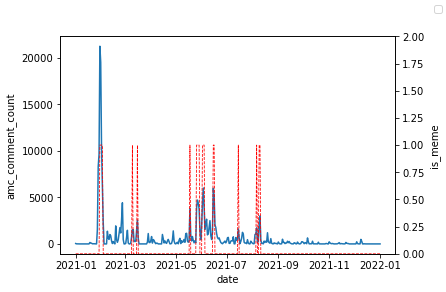

In [4]:
# Check graph
ticker = 'amc'

ax = sns.lineplot(x = 'date', y = '{}_comment_count'.format(ticker), data = df, legend='auto')
ax2 = ax.twinx()
sns.lineplot(x = 'date', y = 'is_meme', data = df, legend='auto', color = 'red', linestyle="dashed", linewidth = 0.8)
ax.figure.legend()
plt.ylim(0,2)
plt.show()

In [27]:
stocks = ['amc', 'bb', 'clov', 'wish', 'pltr', 'tsla', 'amzn', 'nok', 'meta', 'fb']

In [28]:
# Set all parameters here
comments = pd.read_csv('comments_preprocessed_assigned.csv')
fin_data = pd.read_csv('AMC_2021.csv')

In [29]:
comments['ticker'].value_counts()

amc     235141
bb      195023
clov    130118
wish     63366
pltr     57975
tsla     51815
amzn     44102
nok      27400
meta      3241
fb        2008
Name: ticker, dtype: int64

In [30]:
# Drop NA from comments
comments = comments[~comments['created_utc'].isna()]

## Create Daily Count of Comments For Each Ticker

In [31]:
# Grab only the ticker assignment and the date

comment_vol_df = comments[['created_utc', 'ticker']]
comment_vol_df['created_utc'] = pd.to_numeric(comment_vol_df['created_utc'], errors = 'coerce')

# Remove NAs created by the coerce
comment_vol_df = comment_vol_df[~comment_vol_df['created_utc'].isna()]
comment_vol_df['created_utc'] = comment_vol_df['created_utc'].astype(int)

comment_vol_df.head()

,created_utc,ticker
0,1612139703,amc
1,1611968923,amc
2,1611895308,amc
3,1611891585,amc
4,1611889728,amc


In [32]:
comment_vol_df['created_utc'] = pd.to_datetime(comment_vol_df['created_utc'],unit= 's')
comment_vol_df.head()

,created_utc,ticker
0,2021-02-01 00:35:03,amc
1,2021-01-30 01:08:43,amc
2,2021-01-29 04:41:48,amc
3,2021-01-29 03:39:45,amc
4,2021-01-29 03:08:48,amc


In [33]:
comment_vol_df['date'] = comment_vol_df['created_utc'].dt.date
comment_vol_df['date'] = pd.DatetimeIndex(comment_vol_df['date'])
comment_vol_df.head()

,created_utc,ticker,date
0,2021-02-01 00:35:03,amc,2021-02-01
1,2021-01-30 01:08:43,amc,2021-01-30
2,2021-01-29 04:41:48,amc,2021-01-29
3,2021-01-29 03:39:45,amc,2021-01-29
4,2021-01-29 03:08:48,amc,2021-01-29


In [34]:
# Create a binary column for stock
for stock in stocks:
    comment_vol_df[stock] = np.where(comment_vol_df['ticker'] == stock, 1, 0)

In [35]:
aggregations = {}
for stock in stocks:
    aggregations[stock] = np.sum

print(aggregations)

{'amc': <function sum at 0x10a2a4ca0>, 'bb': <function sum at 0x10a2a4ca0>, 'clov': <function sum at 0x10a2a4ca0>, 'wish': <function sum at 0x10a2a4ca0>, 'pltr': <function sum at 0x10a2a4ca0>, 'tsla': <function sum at 0x10a2a4ca0>, 'amzn': <function sum at 0x10a2a4ca0>, 'nok': <function sum at 0x10a2a4ca0>, 'meta': <function sum at 0x10a2a4ca0>, 'fb': <function sum at 0x10a2a4ca0>}


In [36]:
comment_vol_grouped = comment_vol_df.groupby(['date']).agg(aggregations).reset_index().sort_values(['date'])
comment_vol_grouped.head()

,date,amc,bb,clov,wish,pltr,tsla,amzn,nok,meta,fb
0,1970-01-01,3,0,0,0,0,0,0,0,0,0
1,2021-01-01,42,3,0,1,370,2,3,0,0,0
2,2021-01-02,8,3,0,1,31,303,4,0,1,1
3,2021-01-03,4,3,0,0,482,173,5,0,0,2
4,2021-01-04,0,0,0,0,320,161,7,0,0,0


In [37]:
# Only one line of weird values, drop
comment_vol_grouped[comment_vol_grouped['date'] < pd.Timestamp('2021-01-01')]

,date,amc,bb,clov,wish,pltr,tsla,amzn,nok,meta,fb
0,1970-01-01,3,0,0,0,0,0,0,0,0,0


In [38]:
comment_vol_grouped=comment_vol_grouped[~(comment_vol_grouped['date'] < pd.Timestamp('2021-01-01'))]
print(len(comment_vol_grouped))
comment_vol_grouped.head()

390


,date,amc,bb,clov,wish,pltr,tsla,amzn,nok,meta,fb
1,2021-01-01,42,3,0,1,370,2,3,0,0,0
2,2021-01-02,8,3,0,1,31,303,4,0,1,1
3,2021-01-03,4,3,0,0,482,173,5,0,0,2
4,2021-01-04,0,0,0,0,320,161,7,0,0,0
5,2021-01-05,0,1,0,1,122,190,5,0,0,0


## Join Comment Volume to Date

In [39]:
# Build an empty df with date only
start_date = '2021-01-01'
end_date = '2022-01-01'

# Generate a list of month-end closes
start = datetime.datetime.strptime(start_date, "%Y-%m-%d")
end = datetime.datetime.strptime(end_date, "%Y-%m-%d")
date_generated = pd.date_range(start, end, freq='D')

# Format date columns 
df = pd.DataFrame(date_generated)
df.columns = ['date'] # rename column

df.head()

,date
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05


In [40]:
# Left join to Date Range
df = df.merge(comment_vol_grouped, how = 'left', on = 'date')
df = df.fillna(0)
print('Length of DataFrame: {}'.format(len(df)))
df.head()

Length of DataFrame: 366


,date,amc,bb,clov,wish,pltr,tsla,amzn,nok,meta,fb
0,2021-01-01,42.0,3.0,0.0,1.0,370.0,2.0,3.0,0.0,0.0,0.0
1,2021-01-02,8.0,3.0,0.0,1.0,31.0,303.0,4.0,0.0,1.0,1.0
2,2021-01-03,4.0,3.0,0.0,0.0,482.0,173.0,5.0,0.0,0.0,2.0
3,2021-01-04,0.0,0.0,0.0,0.0,320.0,161.0,7.0,0.0,0.0,0.0
4,2021-01-05,0.0,1.0,0.0,1.0,122.0,190.0,5.0,0.0,0.0,0.0


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

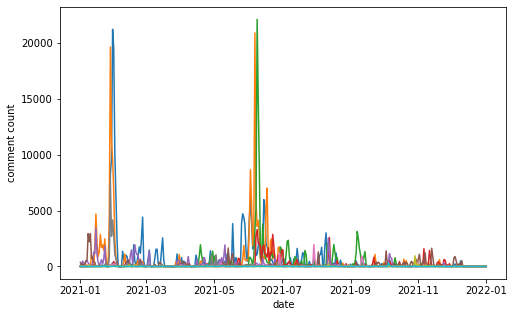

In [42]:
fig, ax = plt.subplots(figsize = (8,5))

for stock in stocks:
    sns.lineplot(x = 'date', y = stock, data = df, legend='auto')

plt.ylabel('comment count')
plt.show()

## Calculate Meme Period by Stock

- Get Weekly Average Comment Volume
- Get 4 Week Moving Average (over a month)
- Weekly more than 3x greater than 4 week MA  = MEME
- Weekly goes back 

Check the trend with Seaborn (viz the comment volume vs meme period)

In [112]:
df_amc = df[['date','amc']]
df_amc['7_day_avg'] = df['amc'].rolling(7).mean() 
df_amc['30_day_avg'] = df['amc'].rolling(30).mean() 
df_amc['is_meme'] = np.where((df_amc['amc'] > df_amc['30_day_avg']*2)
                             & (df_amc['amc']>df_amc['amc'].quantile(0.90))
                             , 1 ,0 )
df_amc

,date,amc,7_day_avg,30_day_avg,is_meme
0,2021-01-01,42.0,NaN,NaN,0
1,2021-01-02,8.0,NaN,NaN,0
2,2021-01-03,4.0,NaN,NaN,0
3,2021-01-04,0.0,NaN,NaN,0
4,2021-01-05,0.0,NaN,NaN,0
...,...,...,...,...,...
361,2021-12-28,0.0,0.714286,36.066667,0
362,2021-12-29,0.0,0.285714,35.900000,0
363,2021-12-30,2.0,0.285714,35.966667,0
364,2021-12-31,2.0,0.571429,35.833333,0


In [113]:
df_amc['amc'].median()

93.0

## Join Financial Data

In [14]:
fin_data.head()

,Unnamed: 0,Open_x,High_x,Low_x,Close_x,Volume_x,Daily%Change,2D%Change,3D%Change,4D%Change,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,date,TICKER,SD
0,0,2.17,2.22,2.08,2.12,28234300,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,2020-12-31,AMC,1.197429
1,1,2.20,2.20,2.00,2.01,29873800,-5.188675,NaN,NaN,NaN,...,0,0,0,0,0,0,0,2021-01-04,AMC,0.788105
2,2,1.99,2.03,1.91,1.98,28148300,-1.492536,-6.603768,NaN,NaN,...,0,0,0,0,0,0,0,2021-01-05,AMC,0.815720
3,3,2.03,2.23,1.97,2.01,67363300,1.515150,0.000000,-5.188675,NaN,...,1,0,0,0,0,0,0,2021-01-06,AMC,2.505572
4,4,2.08,2.11,2.02,2.05,26150500,1.990048,3.535350,1.990048,-3.301884,...,1,1,1,0,0,0,0,2021-01-07,AMC,1.405905


In [19]:
fin_data['date'] = pd.DatetimeIndex(fin_data['date'])
fin_data = fin_data.drop(['Unnamed: 0', 'TICKER'], axis = 1)
fin_data.head()

,Open_x,High_x,Low_x,Close_x,Volume_x,Daily%Change,2D%Change,3D%Change,4D%Change,5D%Change,...,7D%Change,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,date,SD
0,2.17,2.22,2.08,2.12,28234300,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,0,2020-12-31,1.197429
1,2.20,2.20,2.00,2.01,29873800,-5.188675,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,0,2021-01-04,0.788105
2,1.99,2.03,1.91,1.98,28148300,-1.492536,-6.603768,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,0,2021-01-05,0.815720
3,2.03,2.23,1.97,2.01,67363300,1.515150,0.000000,-5.188675,NaN,NaN,...,NaN,1,0,0,0,0,0,0,2021-01-06,2.505572
4,2.08,2.11,2.02,2.05,26150500,1.990048,3.535350,1.990048,-3.301884,NaN,...,NaN,1,1,1,0,0,0,0,2021-01-07,1.405905


In [20]:
df = df.merge(fin_data, how = 'left', on = 'date')
df.head()

,date,amc_comment_count,is_meme,Open_x,High_x,Low_x,Close_x,Volume_x,Daily%Change,2D%Change,...,6D%Change,7D%Change,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD
0,2021-01-01,42.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-02,8.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-03,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-04,0.0,0,2.20,2.20,2.00,2.01,29873800.0,-5.188675,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.788105
4,2021-01-05,0.0,0,1.99,2.03,1.91,1.98,28148300.0,-1.492536,-6.603768,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.815720
